# Run a quantum circuit in Cirq, with a Pasqal device as a backend
<br>
<br>
<div>
<img src="/files/Cirq_pasqal.png" width="700"/>
</div>
<br>
<br>
In this notebook, we show how to program a quantum circuit for Pasqal using cirq, a python framework developped by Google. The first step is to import cirq, and Pasqal custom classes.


In [1]:
import cirq
from cirq import ops
from cirq.pasqal import ThreeDGridQubit, PasqalDevice, PasqalNoiseModel, PasqalSampler

## Create an array of qubits on a lattice
<br>
<br>
The QPU of Pasqal is made of neutral atoms controlled by lasers. Individual atoms are trapped at well-defined positions in 1, 2 or even 3D, as shown on the following plot (Nature 561, 79 (2018)).
<br>
<br>


<div>
<img src="files/eiffel_tower.png" width="500"/>
</div>
<br>
<br>
We created a custom class in cirq, ThreeDGridQubit, that corresponds to a qubit placed on a 3D grid. Let us start by creating a register comprising $36=6\times6$ qubits in 2D, regularly arranged on a square lattice. It corresponds to the following configuration (image taken from Nature 561, 79 (2018)):

<div>
<img src="files/grid_atoms.png" width="300"/>

In [2]:
width=6
height=6
depth=1
# Creating p_qubits, a list of ThreeDGridQubit.
p_qubits=[ThreeDGridQubit(row, col, lay) 
          for row in range(width) 
          for col in range(height)
          for lay in range(depth)]

## Create a PasqalDevice
<br>
<br>
Multi-qubit gates can be applied between qubits in the device, provided that the distance between them is smaller than the so-called Rydberg blocade radius (or control radius), that can be passed as a parameter of the device (in units of the lattice size). Here, we instantiate a PasqalDevice with 36 qubits and a control radius of $2.1$. 
<br>
<br>
Using the Circuit class of Cirq, one can then build a circuit that will be implemented with a PasqalDevice as a backend.
<br>

In [3]:
# Create a Pasqal device with a control radius of 2.1 (in units of the lattice spacing)
p_device=PasqalDevice(control_radius=2.1, qubits=p_qubits)

In [4]:
# Create a circuit, specifying the device
p_circuit = cirq.Circuit(device=p_device)

# Adding gates to that circuit
p_circuit.append(cirq.CZ(p_qubits[0], p_qubits[1]))
p_circuit.append(cirq.Z(p_qubits[0]))
p_circuit.append(cirq.CX(p_qubits[0], p_qubits[2]))


In [5]:
print(p_circuit)

(0, 0, 0): ───@───Z───@───
              │       │
(0, 1, 0): ───@───────┼───
                      │
(0, 2, 0): ───────────X───


When the distance between the two qubits involved in the gate is greater than the control radius, as shown for example in the following plot, cirq will throw an error.
<br>
<br>
<div>
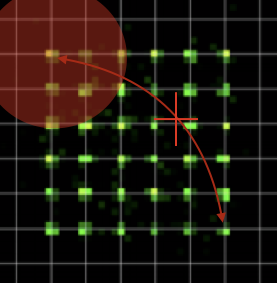

In [6]:
# It is impossible to add a multi-qubit gate if the qubits involved are too far away
p_circuit.append(cirq.CZ(p_qubits[0], p_qubits[-1]))

ValueError: Qubits pasqal.ThreeDGridQubit(0, 0, 0), pasqal.ThreeDGridQubit(5, 5, 0) are too far away

## Send a circuit to a remote Pasqal machine
<br>
<br>
Using the Circuit class of Cirq, one can then build a circuit that will be implemented with a PasqalDevice as a backend.
<br>
<br>
The real QPU is not plugged in yet as a backend. If you send us your circuit, we currently use a classical emulator as a backend to determine the result of your simulation. As emulating a quantum circuit with a large number of qubits is computationnaly intensive, here we choose to realize a circuit on a smaller register.
<br>
<br>
More precisely, we will implement Shor’s quantum factoring algorithm, as presented in Nature 414, 883-887 (2001). Here is the corresponding quantum circuit (see also "Quantum Algorithm Implementations for Beginners", arxiv:1804.03719):
<br>
<br>

<div>
<img src="files/shor_circuit.png" width="600"/>
<br>
<br>
Here the cirq implementation of the circuit:


In [7]:
import numpy as np

qs = [ThreeDGridQubit(0, 0, 0), ThreeDGridQubit(0, 1, 0), ThreeDGridQubit(0, 2, 0),\
      ThreeDGridQubit(1, 0, 0), ThreeDGridQubit(1, 1, 0)]
q_mes=[qs[2], qs[1], qs[0]]
device = cirq.pasqal.PasqalDevice(control_radius=2.5, qubits=qs)
pi_over_2_gate=cirq.CZPowGate(exponent=np.pi/2.)
pi_over_4_gate=cirq.CZPowGate(exponent=np.pi/4.)

shor_circuit = cirq.Circuit(device=device)

shor_circuit.append(cirq.H(qs[0]))
shor_circuit.append(cirq.H(qs[1]))
shor_circuit.append(cirq.H(qs[2]))

shor_circuit.append(cirq.CX(qs[2],qs[3]))
shor_circuit.append(cirq.CX(qs[2],qs[4]))
shor_circuit.append(cirq.H(qs[1]))
shor_circuit.append(pi_over_2_gate(qs[1],qs[0]))
shor_circuit.append(cirq.H(qs[0]))
shor_circuit.append(pi_over_4_gate(qs[1],qs[2]))
shor_circuit.append(pi_over_2_gate(qs[0],qs[2]))
shor_circuit.append(cirq.measure(*q_mes, key='x'))

Now, one has to create a sampler  that will send your circuit to the remote host address. One currently needs a token to have access to our servers. Please contact us to get one !

In [8]:
sampler = sampler = cirq.pasqal.PasqalSampler(
        remote_host='http://34.98.71.118/v0/pasqal',
        access_token=PASQAL_API_ACCESS_TOKEN
    )
data_raw = sampler.run(program=shor_circuit, repetitions=200)

Next, we can plot the results obtained.

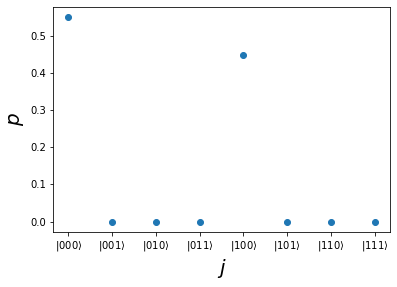

In [9]:
import matplotlib.pyplot as plt


data0 = data_raw.data.to_dict()
vec=[j for j in range(8)]
res=np.zeros(len(vec))
for jj in range(200):
    number = data0['x'][jj]
    res[number] += 1
res=res/200.

fig = plt.figure()
ax = fig.add_axes([0.16, 0.16, 0.78, 0.78])
ax.plot(vec, res,'o')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels([r'$|000\rangle$',r'$|001\rangle$', r'$|010\rangle$', r'$|011\rangle$',\
                    r'$|100\rangle$', r'$|101\rangle$', r'$|110\rangle$', r'$|111\rangle$'])
plt.xlabel(r'$j$', fontsize=20)
plt.ylabel(r'$p$', fontsize=20)
plt.show()

The register is in a mixture of $|000\rangle=|0\rangle$ and $|100\rangle=|4\rangle$. Aside from the trivial result $|0\rangle$, the large probability of measuring $|4\rangle$ directly leads to the factorisation of $15=5\times 3$ (more details on Shor's algorithm, period finding and their implementations in Nature 414, 883-887 (2001) and Phys. Rev. Lett. 85 (25), 5452 (2000))

## Incorporate the effect of noise during a classical emulation of the circuit
<br>
<br>
Current NISQ processors are imperfect and prone to errors. We incorporated in Cirq a typical noise model for Pasqal devices, that can be used when one emulates the behavior of the device with a classical computer.
<br>

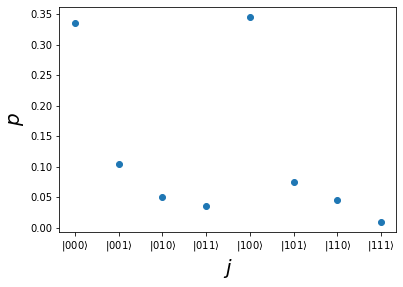

In [10]:
qs = [ThreeDGridQubit(0, 0, 0), ThreeDGridQubit(0, 1, 0), ThreeDGridQubit(0, 2, 0),\
      ThreeDGridQubit(1, 0, 0), ThreeDGridQubit(1, 1, 0)]
q_mes=[qs[2], qs[1], qs[0]]

device = cirq.pasqal.PasqalDevice(control_radius=2.5, qubits=qs)
pi_over_2_gate=cirq.CZPowGate(exponent=np.pi/2.)
pi_over_4_gate=cirq.CZPowGate(exponent=np.pi/4.)

shor_circuit = cirq.Circuit(device=device)
shor_circuit.append(cirq.H(qs[0]))
shor_circuit.append(cirq.H(qs[1]))
shor_circuit.append(cirq.H(qs[2]))
shor_circuit.append(cirq.CX(qs[2],qs[3]))
shor_circuit.append(cirq.CX(qs[2],qs[4]))
shor_circuit.append(cirq.H(qs[1]))
shor_circuit.append(pi_over_2_gate(qs[1],qs[0]))
shor_circuit.append(cirq.H(qs[0]))
shor_circuit.append(pi_over_4_gate(qs[1],qs[2]))
shor_circuit.append(pi_over_2_gate(qs[0],qs[2]))

# Use the custom noise model of Pasqal devices
noise_model = PasqalNoiseModel()
shor_circuit = shor_circuit.with_noise(noise_model)

shor_circuit.append(cirq.measure(*q_mes, key='x'))

# Run a cirq simulator locally
simulator = cirq.Simulator()
data_raw = simulator.run(shor_circuit, repetitions=200)

# Plot the results
data0 = data_raw.data.to_dict()
vec=[j for j in range(8)]
res=np.zeros(len(vec))
for jj in range(200):
    number = data0['x'][jj]
    res[number] += 1
res=res/200.

fig = plt.figure()
ax = fig.add_axes([0.16, 0.16, 0.78, 0.78])
ax.plot(vec, res,'o')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels([r'$|000\rangle$', r'$|001\rangle$', r'$|010\rangle$', r'$|011\rangle$',\
                    r'$|100\rangle$', r'$|101\rangle$', r'$|110\rangle$', r'$|111\rangle$'])
plt.xlabel(r'$j$', fontsize=20)
plt.ylabel(r'$p$', fontsize=20)
plt.show()

One still finds a rather large probability to measure $|4\rangle$, but we note the possibility of wrong measurement outcomes, due to the presence of noise.